In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [ ]:
BATCH_SIZE = 128

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=.5, std=.5)
])

dataset = torchvision.datasets.MNIST(root='data/',
                           download=True,
                           train=True,
                           transform=transform)

data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 237068842.84it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 11790509.42it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 69419932.91it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7921217.78it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super().__init__()

    self.noise_dim = noise_dim
    self.layers = nn.Sequential(
        self.get_block(noise_dim, 256, (3, 3), 2),
        self.get_block(256, 128, (4, 4), 1),
        self.get_block(128, 64, (3, 3), 2),
        self.get_block(64, 1, (4, 4), 2, True),
    )

  def forward(self, x):
    x = x.view(-1, self.noise_dim, 1, 1)
    return self.layers(x)

  def get_block(self, in_channels, out_channels, kernel_size, strides, final_layer=False):
    if final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, strides),
          nn.Tanh()
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, strides),
          nn.BatchNorm2d(out_channels),
          nn.ReLU()
      )

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
        self.get_block(1, 16, (3, 3), 2),
        self.get_block(16, 32, (5, 5), 2),
        self.get_block(32, 64, (5, 5), 2),

        nn.Flatten(),

        nn.Linear(64, 1)
    )
  
  def forward(self, x):
    return self.layers(x)

  def get_block(self, in_channels, out_channels, kernel_size, strides):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(.2)
    )

In [ ]:
def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight, .0, .02)
  if isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight, .0, .02)
    nn.init.constant_(m.bias, 0)

In [ ]:
noise_dim = 64

generator = Generator(noise_dim).apply(weights_init).to(device)
discriminator = Discriminator().apply(weights_init).to(device)

In [ ]:
noise = torch.randn(size=(2, noise_dim), device=device)
images = generator(noise)
preds = discriminator(images)

In [ ]:
LR = 2e-4
betas = (.5, .99)

generator_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=betas)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=betas)

loss = nn.BCEWithLogitsLoss()

In [ ]:
def plot_images(images):
  images = images.detach().cpu()
  count = images.shape[0]

  fig, ax = plt.subplots(1, count, figsize=(15, 5))
  
  for i in range(count):
    # img = (images[i].squeeze() + 1) / 2
    ax[i].imshow(images[i].squeeze().numpy(), cmap='gray')

  plt.show()

  0%|          | 0/469 [00:00<?, ?it/s]

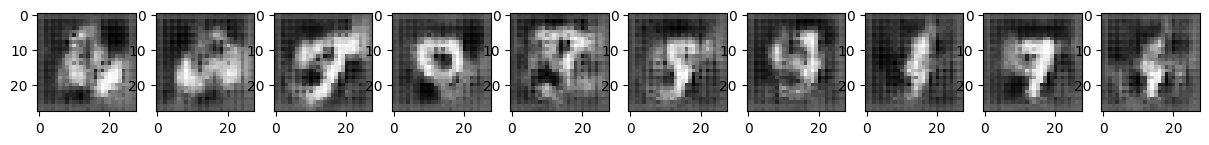

  0%|          | 0/469 [00:00<?, ?it/s]

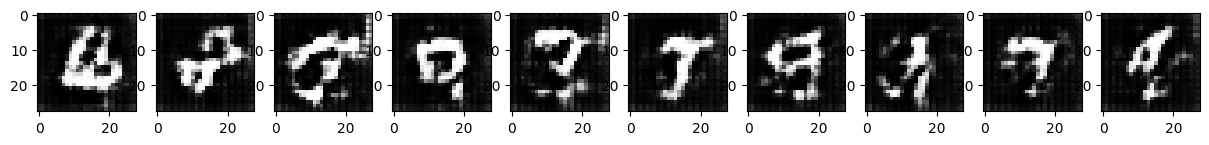

  0%|          | 0/469 [00:00<?, ?it/s]

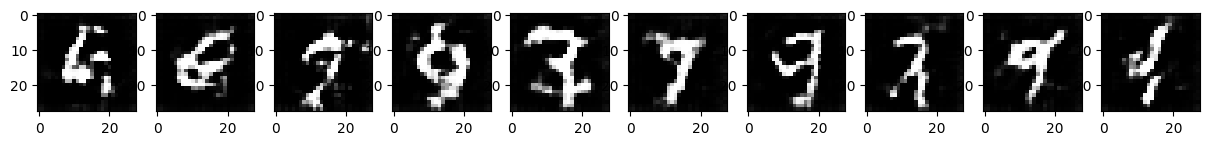

  0%|          | 0/469 [00:00<?, ?it/s]

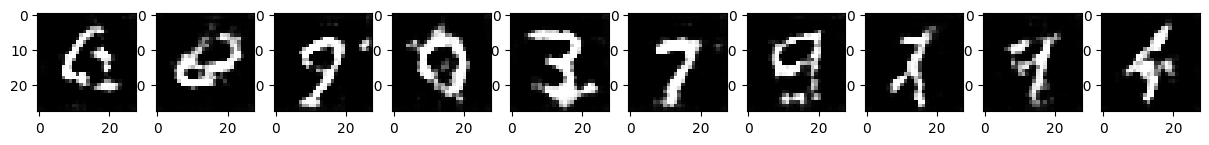

  0%|          | 0/469 [00:00<?, ?it/s]

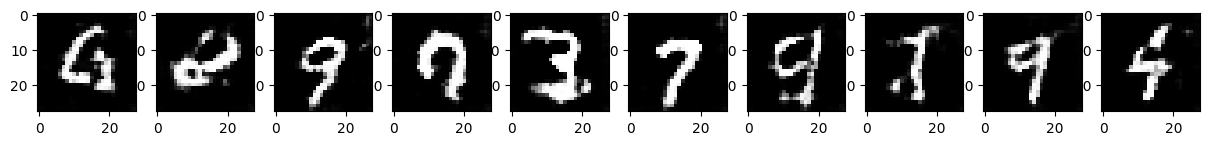

  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
epochs = 20
plot_noise = torch.randn(size=(10, noise_dim), device=device)

for i in range(epochs):
  for x, y in tqdm(data_loader):
    x = x.to(device)

    # Training the discriminator
    discriminator_optimizer.zero_grad()

    real_preds = discriminator(x)

    noise = torch.randn(size=(x.shape[0], noise_dim), device=device)
    generated_images = generator(noise).detach()
    generated_preds = discriminator(generated_images)

    real_labels = torch.ones_like(real_preds, dtype=torch.float32, device=device)
    generated_labels = torch.zeros_like(generated_preds, dtype=torch.float32, device=device)
    
    real_loss = loss(real_preds, real_labels)
    generated_loss = loss(generated_preds, generated_labels)

    total_loss = (real_loss + generated_loss) / 2

    total_loss.backward()
    discriminator_optimizer.step()

    # Training the generator
    generator_optimizer.zero_grad()

    noise = torch.randn(size=(x.shape[0], noise_dim), device=device)
    generated_images = generator(noise)
    generated_preds = discriminator(generated_images)

    generated_labels = torch.ones_like(generated_preds, dtype=torch.float32, device=device)
    generated_loss = loss(generated_preds, generated_labels)

    generated_loss.backward()
    generator_optimizer.step()

  with torch.no_grad():
    images = generator(plot_noise)
    plot_images(images)

In [ ]:
with torch.no_grad():
  for i in range(10):
    noise = torch.randn(size=(10, noise_dim), device=device)
    images = generator(noise)
    plot_images(images)